# Variational Basis State Encoder (Ground State)

## 1 Backgroud
This tutorial is for variational basis state encoder (VBE) for the ground state of the Holstein model.

$$ \hat{H} = -\sum_{i,j} V \hat{a}_i^\dagger \hat{a}_j + \sum_i \omega \hat{b}_i^\dagger \hat{b}_i + \sum_i g\omega \hat{a} _i^\dagger \hat{a}_i (\hat{b}_i^\dagger + \hat{b}_i) $$

To calculate the ground state of Holstein model accurately, many levels of phonons are needed, which will cost too many qubits in quantum circuit. There exists another idea that we can view linear conbination of phonons as an effective phonon mode, which is possible to save the qubits in phonon encoding:

$$\hat{B}[l]=\sum_{n=1}^{2^{N_l}} \ket{n}_l\sum_m C[l]_{mn} \bra{m}_l$$

Here, we transform the original phonon basis $\ket{m}$ to the encoded basis $\ket{n}$, via transformation operator $\hat{B}[l]$. The form of $\hat{B}[l]$ is the central of VBE and the algorithm are presented in section 2. For more details, see https://doi.org/10.1103/PhysRevResearch.5.023046

## 2 Algorithm Realization

### 2.1 Imports

In [1]:
import numpy as np
import scipy
from opt_einsum import contract
import tensorcircuit as tc

from tencirchem import set_backend, Op, BasisSHO, BasisSimpleElectron, Mpo, Model
from tencirchem.dynamic import get_ansatz, qubit_encode_op, qubit_encode_basis
from tencirchem.utils import scipy_opt_wrap
from tencirchem.applications.vbe_lib import get_psi_indices, get_contracted_mpo, get_contract_args

## 2.2 Initial setups
In this section, we set intital parameters for coming sections. Here, `JAX` is used as backend. `nsite`, `omega`, `v` correspond to the site number, phonon frequency $\omega$, transfer intergral $V$ in Holstein model, respectively:

$$ \hat{H} = -\sum_{i,j} V \hat{a}_i^\dagger \hat{a}_j + \sum_i \omega \hat{b}_i^\dagger \hat{b}_i + \sum_i g\omega \hat{a} _i^\dagger \hat{a}_i (\hat{b}_i^\dagger + \hat{b}_i) $$

Each site possesses one phonon mode, which is represented by 2 qubit per phonon (see `n_qubit_per_mode`). Considering gray encoding is adopted, the number of phonon basis (`nbas_v`) is $2^2$. `psi_index_top` and `psi_index_bottom` correspond to the physical index of ket and bra, `b_dof_vidx` correspond to the qubits that need VBE, `psi_shape2` is the physical bond dimension of each qubit state.
The stucture of wavefunction and operator are presented in Fig.1. Note that the related arguments and functions are also marked.
![fig1](../statics/vbe_gs_Fig1.svg)
Fig. 1 The structure of wavefunction and operator. Blue squares correspond to qubit representing spin, green circles correspond to qubits representing vibrations, purple circles correspond to $B[l]$, and orange squares correspond to Matrix Product Operators (MPO).

In [2]:
backend = set_backend("jax")

nsite = 3
omega = 1
v = 1
# two qubit for each mode
# modify param_ids before modifying this
n_qubit_per_mode = 2
nbas_v = 1 << n_qubit_per_mode

# -1 for electron dof, natural numbers for phonon dof
dof_nature = np.array([-1, 0, 0, -1, 1, 1, -1, 2, 2])
# physical index for phonon mode
b_dof_pidx = np.array([1, 3, 5])

psi_idx_top, psi_idx_bottom, b_dof_vidx = get_psi_indices(dof_nature, b_dof_pidx, n_qubit_per_mode)

n_dof = len(dof_nature)
psi_shape2 = [2] * n_dof

print(
    "psi_index_top: ",
    psi_idx_bottom,
    "\n psi_index_bottom: ",
    psi_idx_bottom,
    "\n b_dof_vidx: ",
    b_dof_vidx,
    "\n psi_shape2: ",
    psi_shape2,
)

c = tc.Circuit(nsite * 3)  # generate quantum circuit
c.X(0)  # prepare one-electron initial state
n_layers = 3  # layers of ansatz

2023-08-08 15:44:36.794994: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


psi_index_top:  ['p-0-bottom', 'v-1-0-bottom', 'v-1-1-bottom', 'p-2-bottom', 'v-3-0-bottom', 'v-3-1-bottom', 'p-4-bottom', 'v-5-0-bottom', 'v-5-1-bottom'] 
 psi_index_bottom:  ['p-0-bottom', 'v-1-0-bottom', 'v-1-1-bottom', 'p-2-bottom', 'v-3-0-bottom', 'v-3-1-bottom', 'p-4-bottom', 'v-5-0-bottom', 'v-5-1-bottom'] 
 b_dof_vidx:  [array([1, 2]), array([4, 5]), array([7, 8])] 
 psi_shape2:  [2, 2, 2, 2, 2, 2, 2, 2, 2]


## 2.3 Get Variational Hamiltonian Ansatz (VHA) Terms
In this section, we will generate variational hamiltonian ansatz terms. The following ansatz is adopted:

$$\ket{\phi}=\prod_l^L {\prod_{<j,k>} e^{\theta_{ijk} {(\hat{a}_j^\dagger \hat{a}_k - \hat{a}_k^\dagger \hat{a}_j)}} 
\prod_j {e^{\theta_{lj}\hat{a}_j^\dagger \hat{a}_j (\hat{b}_j^\dagger - \hat{b}_j)}}} \ket{\phi_0} $$

The anasatz is transformed from electron-phonon basis to qubit basis through `qubit_encode_op()` and `qubit_encode_basis()`

In [3]:
def get_vha_terms():
    # variational Hamiltonian ansatz (vha) terms

    g = 1  # dummy value, doesn't matter
    ansatz_terms = []
    for i in range(nsite):
        j = (i + 1) % nsite
        ansatz_terms.append(Op(r"a^\dagger a", [i, j], v))
        ansatz_terms.append(Op(r"a^\dagger a", [j, i], -v))
        ansatz_terms.append(Op(r"a^\dagger a b^\dagger-b", [i, i, (i, 0)], g * omega))

    basis = []
    for i in range(nsite):
        basis.append(BasisSimpleElectron(i))
        basis.append(BasisSHO((i, 0), omega, nbas_v))

    ansatz_terms, _ = qubit_encode_op(ansatz_terms, basis, boson_encoding="gray")
    spin_basis = qubit_encode_basis(basis, boson_encoding="gray")
    # this is currently hard-coded for `n_qubit_per_mode==2`
    # if the values of param_ids are opposite to each other, the values of the parameters are forced to be opposite in the optimization.
    param_ids = [1, -1, 0, 2, 3, 4, 5, 6, 7, 8] + [9, -9] + list(range(10, 18)) + [18, -18] + list(range(19, 27))
    return ansatz_terms, spin_basis, param_ids


ansatz_terms, spin_basis, param_ids = get_vha_terms()
ansatz = get_ansatz(ansatz_terms, spin_basis, n_layers, c, param_ids)

print(
    "ansatz_terms: \n",
    ansatz_terms,
    "\nspin_basis: \n",
    spin_basis,
    "\nparam_ids: \n",
    param_ids,
    "\nansatz: \n",
    ansatz,
)

ansatz_terms: 
 [Op('X Y', [0, 1], 0.5j), Op('Y X', [0, 1], -0.5j), Op('Y', [((0, 0), 'TCCQUBIT-1')], 0.1830127018922193j), Op('Z Y', [((0, 0), 'TCCQUBIT-0'), ((0, 0), 'TCCQUBIT-1')], -0.6830127018922193j), Op('Y', [((0, 0), 'TCCQUBIT-0')], -0.3535533905932738j), Op('Y Z', [((0, 0), 'TCCQUBIT-0'), ((0, 0), 'TCCQUBIT-1')], 0.3535533905932738j), Op('Z Y', [0, ((0, 0), 'TCCQUBIT-1')], -0.1830127018922193j), Op('Z Z Y', [0, ((0, 0), 'TCCQUBIT-0'), ((0, 0), 'TCCQUBIT-1')], 0.6830127018922193j), Op('Z Y', [0, ((0, 0), 'TCCQUBIT-0')], 0.3535533905932738j), Op('Z Y Z', [0, ((0, 0), 'TCCQUBIT-0'), ((0, 0), 'TCCQUBIT-1')], -0.3535533905932738j), Op('X Y', [1, 2], 0.5j), Op('Y X', [1, 2], -0.5j), Op('Y', [((1, 0), 'TCCQUBIT-1')], 0.1830127018922193j), Op('Z Y', [((1, 0), 'TCCQUBIT-0'), ((1, 0), 'TCCQUBIT-1')], -0.6830127018922193j), Op('Y', [((1, 0), 'TCCQUBIT-0')], -0.3535533905932738j), Op('Y Z', [((1, 0), 'TCCQUBIT-0'), ((1, 0), 'TCCQUBIT-1')], 0.3535533905932738j), Op('Z Y', [1, ((1, 0), 'TCC

## 2.4 Cost Functions for VQE Part
The VQE parameters $\theta_k$ are optimized via following equation:

$$\partial {\bra{\phi}\hat{H}_1\ket{\phi}}/\partial {\theta_k} = 0$$

where

$$\hat{H}_1=\prod_{l}\hat{B}[l] \hat{H} \prod_{l}\hat{B}[l]^\dagger$$

In [4]:
def cost_fn(params, h):
    state = ansatz(params)
    return (state.conj() @ (h @ state)).squeeze().real


vg = backend.jit(backend.value_and_grad(cost_fn))
opt_fn = scipy_opt_wrap(vg)

## 2.5 Get Hamiltonian Terms and Basis
In this section, we generate the operator of the Holstein Hamiltonian presented in Section 2.2. The format of the operator are shown in Fig. 1. Note that the number of phonon levels are controlled by `nbas`.

In [5]:
def get_ham_terms_and_basis(g, nbas):
    terms = []
    for i in range(nsite):
        terms.append(Op(r"b^\dagger b", (i, 0), omega))
        terms.append(Op(r"a^\dagger a b^\dagger+b", [i, i, (i, 0)], g * omega))
        j = (i + 1) % nsite
        terms.append(Op(r"a^\dagger a", [i, j], -v))
        terms.append(Op(r"a^\dagger a", [j, i], -v))

    basis = []
    for i in range(nsite):
        basis.append(BasisSimpleElectron(i))
        basis.append(BasisSHO((i, 0), omega, nbas))

    return terms, basis

## 2.6 Update $B[l]$ in Iteration
In this section, the function that calculates $B[l]$ are defined:

$$(1-\hat{P}[l])\bra{\phi}\tilde{H'}\ket{\phi}=0$$

where

$$\hat{P}[l]=\hat{B}[l]^\dagger\hat{B}[l]$$

and

$$\tilde{H'}=\hat{H}_{contracted}\hat{B}[l]^\dagger=\left( \prod_{k\neq l}\hat{B}[l] \hat{H} \prod_{k\neq l}\hat{B}[k]^\dagger \right) \hat{B}[l]^\dagger$$

The graphic representarion of `h_contracted` is presented in Fig. 2. Obiviously, if $\hat{H}$ are provided, we can obtain $\hat{B}[l]$ by solving the equation mentioned above. Considering this is a non-linear equation, several initial guesses are needed to avoid local minimum, which is controlled by `nroot`.
![fig2](../statics/vbe_gs_Fig2.svg)
Fig. 2 Graphic representation of `h_contracted`

In [6]:
def solve_b_array(psi, h_mpo, b_array, i):
    nbas = b_array.shape[-1]
    # get the input of tensor contraction function `contract`
    args = get_contract_args(psi, h_mpo, b_array, i, n_qubit_per_mode, psi_idx_top, psi_idx_bottom, b_dof_pidx)
    k = b_dof_pidx[i]
    # output indices
    args.append(
        [
            f"v-{k}-0-bottom",
            f"v-{k}-1-bottom",
            f"p-{k}-bottom",
            f"v-{k}-0-top",
            f"v-{k}-1-top",
            f"p-{k}-top",
            "mpo-0",
            f"mpo-{len(h_mpo)}",
        ]
    )
    # get contracted_h and reshape the dofs named v-{k}-0-bottom(top) and v-{k}-1-bottom(top) to one dof with dimension 4
    contracted_h = contract(*args).reshape(4, nbas, 4, nbas)
    nroot = 3

    def f(x):
        x = x.reshape(nroot, 4, nbas)
        # calculate P[l]
        p = contract("abc, abd -> acd", x.conj(), x)
        return contract("abcd, kab, kde -> kce", contracted_h, x, (np.array([np.eye(nbas)] * nroot) - p)).ravel()

    # solve the equation mentioned above to obtain B[l]
    sols = scipy.optimize.root(f, [b_array[i].flatten()] * nroot, method="df-sane").x.reshape(3, 4, nbas)

    sols = list(sols) + [b_array[i].copy()]
    b_array = b_array.copy()
    es = []
    for k, new_b in enumerate(sols):
        # ensure the orthomormal constraint of B[l]
        if not np.allclose(new_b @ new_b.T, np.eye(4)):
            # print(f"Enforcing orthogonality for the {k}th root of b_array[{i}]")
            new_b = np.linalg.qr(new_b.T)[0].T
        b_array[i] = new_b
        e = psi @ get_contracted_mpo(h_mpo, b_array, n_qubit_per_mode, b_dof_pidx, psi_idx_top + psi_idx_bottom) @ psi
        es.append(e)
    # print(np.array(es))
    lowest_id = np.argmin(es)
    return sols[lowest_id]

## 2.7 Main Structure of the Function
This section is the main part of the funtion. The codes contain following parts:
(i) Initialize the parameters and functions, some initializations are also preformed in section 2.2
(ii) Search for ground state, where $\theta_k$ are updated via VQE and $B[l]$ are calculated via functions in Section 2.6.

In [7]:
vqe_e = []
thetas = np.zeros((max(param_ids) + 1) * n_layers)

for g in [1.5, 3]:
    for nbas in [4, 8, 12, 16, 20, 24, 28, 32]:
        print(f"g: {g}, nbas: {nbas}")

        # take gray encoding as an initial guess for `b_array`
        b_list = []
        for i in range(max(dof_nature) + 1):
            b = np.eye(nbas)[:nbas_v]  # nbas_dummy * nbas
            b_list.append(b)
        b_array = np.array(b_list)

        # initialize, get hamitonians and basis, see section 2.5
        terms, basis = get_ham_terms_and_basis(g, nbas)
        model = Model(basis, terms)
        h_mpo = Mpo(model)

        # searching for the ground state.
        for i_iter in range(10):
            h_contracted = get_contracted_mpo(
                h_mpo, b_array, n_qubit_per_mode, b_dof_pidx, psi_idx_top + psi_idx_bottom
            )
            # get \theta_k via VQE
            opt_res = scipy.optimize.minimize(opt_fn, args=(h_contracted,), x0=thetas / 2, jac=True, method="L-BFGS-B")
            print(f"Iter {i_iter} VQE energy: {opt_res.fun}")
            thetas = opt_res.x
            psi = ansatz(thetas).real
            # Update b[l] via functions in section 2.6
            for i in range(len(b_array)):
                b_array[i] = solve_b_array(psi, h_mpo, b_array, i)
        vqe_e.append(opt_res.fun)

    print(vqe_e)

g: 1.5, nbas: 4
Iter 0 VQE energy: -3.1462862688238387
Iter 1 VQE energy: -3.1467101393155392
Iter 2 VQE energy: -3.1516072207104755
Iter 3 VQE energy: -3.146809472707097
Iter 4 VQE energy: -3.1436199703762058
Iter 5 VQE energy: -3.1436211792549265
Iter 6 VQE energy: -3.1436161320531255
Iter 7 VQE energy: -3.1436163145946456
Iter 8 VQE energy: -3.143610688816215
Iter 9 VQE energy: -3.143615904093609
g: 1.5, nbas: 8
Iter 0 VQE energy: -3.143618182488605
Iter 1 VQE energy: -3.200840457440427
Iter 2 VQE energy: -3.2122982581916806
Iter 3 VQE energy: -3.2148415941913107
Iter 4 VQE energy: -3.214454540682066
Iter 5 VQE energy: -3.214612010154128
Iter 6 VQE energy: -3.2147110746262615
Iter 7 VQE energy: -3.2147665497225395
Iter 8 VQE energy: -3.2148131940534586
Iter 9 VQE energy: -3.2154252365889784
g: 1.5, nbas: 12
Iter 0 VQE energy: -3.1514261568965116
Iter 1 VQE energy: -3.207712921399021
Iter 2 VQE energy: -3.2143507766993564
Iter 3 VQE energy: -3.2151165867343625
Iter 4 VQE energy: -3.2

Text(0, 0.5, 'Energy')

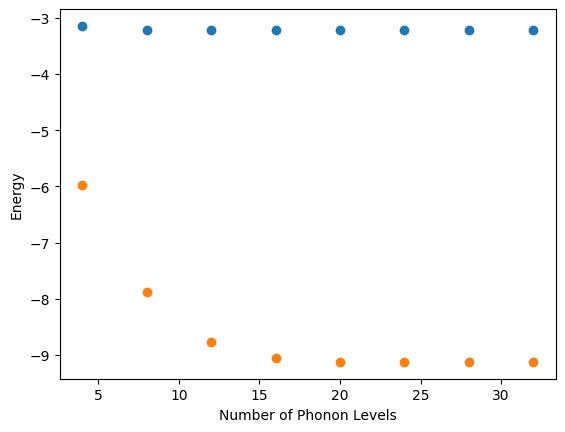

In [8]:
# plot the results
from matplotlib import pyplot as plt

nbas = [4, 8, 12, 16, 20, 24, 28, 32]
plt.scatter(nbas, vqe_e[0:8], label="g=1.5")
plt.scatter(nbas, vqe_e[8:], label="g=3.0")
plt.xlabel("Number of Phonon Levels")
plt.ylabel("Energy")